In [574]:
from typing import Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
import numba

In [637]:
n_train = 10
x_train = np.random.uniform(low=-20, high=20, size=(n_train,1))
y_train = np.random.normal(size=(n_train,))

In [638]:
class GPRegressor:
    """Perform regression using gaussian process with zero mean.

    Attributes
    ----------
    covar : np.ndarray
        The covariance matrix given by k(x_train, x_train) + I*eps.
    covar_inv : np.ndarray
        The inverse of `covar`.
    var_eps : float
        The variance noise gaussian noise $y_i = f_i + epsilon_i$, where
        epsilon_i ~ \mathcal{N}(0, var_eps)
    kernel : callable
        Vectorized kernel function to act as a proxy for covariances. Should give 0
        if inputs are extreme different and should rise as inputs become similar.
    kernel_kwargs : dict
        Extra keyword arguments to pass into the kernel.
    x_train : np.ndarray
        A D x N matrix with the training inputs.
    y_train: an N dimensional array with the training outputs.
    See:
    https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote15.html
    """

    covar: np.ndarray
    covar_inv: np.ndarray
    var_eps: float
    kernel: callable
    kernel_kwargs: dict

    def __init__(
        self, var_eps: float, kernel: callable, kernel_kwargs: Optional[dict] = None
    ) -> None:
        """Set parameters for the class. See class docstring for arguments."""
        self.var_eps = var_eps
        self.kernel = kernel
        self.kernel_kwargs = kernel_kwargs or dict()

    def fit(self, x_train: np.ndarray, y_train: np.ndarray) -> None:
        """Make as many calculations as possible before inference time.
        Which is really calculating and setting `covar` and  `covar_inv`.
        """
        self.x_train = x_train
        self.y_train = y_train
        self.covar = (
            self.kernel(x_train, x_train, **self.kernel_kwargs)
            + np.eye(len(x_train)) * self.var_eps
        )
        self.covar_inv = np.linalg.inv(self.covar)

    def predict(self, x_star: np.array) -> Tuple[np.array, np.array]:
        """Find $p(f_star | x_train, y_train)$

        Parameters
        ----------
        x_start : np.array
            The inputs

        Returns
        -------
        mu_star : np.array
            The mean of f_star.
        covar_star : np.ndarray
            The covariance of f_star. Use the diag of this for variance of individual
            outputs.

        """
        # If the joint $p(f*, f)$ is gaussian, so is the conditional $p(f* | f)$.
        k_star = self.kernel(self.x_train, x_star, **self.kernel_kwargs)
        k_2star = (
            self.kernel(x_star, x_star, **self.kernel_kwargs)
            + np.eye(len(x_star)) * self.var_eps
        )
        mu_star = k_star.T @ self.covar_inv @ y_train
        covar_star = k_2star - k_star.T @ self.covar_inv @ k_star
        return mu_star, covar_star

In [641]:
kernel_kwargs = {"s2": 10, "t":1}
gp_regressor = GPRegressor(var_eps = 00.01, kernel=kernel, kernel_kwargs = kernel_kwargs)
gp_regressor.fit(x_train, y_train)
mu_star, covar_star = gp_regressor.predict(x_test)
sigma_star = np.diag(covar_star) ** 0.5

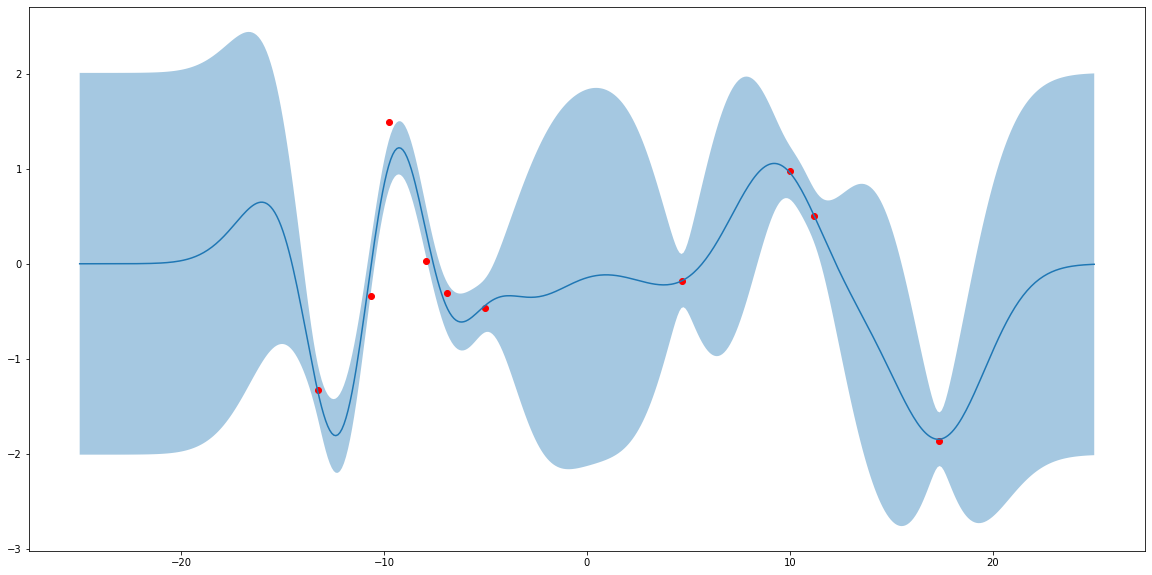

In [642]:
plt.figure(figsize=(20, 10))
plt.plot(x_train, y_train, "ro")
plt.plot(x_test, mu_star)
plt.fill_between(x_test.reshape(-1), mu_star + 2 * sigma_star, mu_star - 2 * sigma_star, alpha=0.4)